In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import warnings
import time
import sys
import datetime
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import BayesianRidge
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import gc
pd.set_option('display.width',None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 500)
np.random.seed(4950)

In [4]:
train = pd.read_csv("./data/pre_train_clip.csv", index_col=0)
train.drop(columns=[
    'hist_first_year', 'hist_first_quarter', 'hist_first_month',
    'hist_now_year', 'hist_now_quarter', 'hist_now_month',
    
    'hist_installments_sum', 'hist_i_vs_p2p',
    'new_installments_sum', 'new_i_vs_p2p',
    'c_i_diff', 'p2p_i_diff',
    
#     'hist_sleep', 'hist_sleep_vs_count', 'hist_sleep_vs_p2p',
#     'new_sleep', 'new_sleep_vs_count', 'new_sleep_vs_p2p',
#     'c_sleep_diff', 'p2p_sleep_diff', 
    
#     'c_p2p_diff_vs', 'c_sleep_diff_vs', 'c_p_diff_vs', 
    'c_i_diff_vs',
#     'p2p_count_diff_vs', 'p2p_sleep_diff_vs', 'p2p_p_diff_vs', 
    'p2p_i_diff_vs'
                   ], inplace=True)

test = pd.read_csv("./data/pre_test_clip.csv", index_col=0)
test.drop(columns=[
    'hist_first_year', 'hist_first_quarter', 'hist_first_month',
    'hist_now_year', 'hist_now_quarter', 'hist_now_month',
    
    'hist_installments_sum', 'hist_i_vs_p2p',
    'new_installments_sum', 'new_i_vs_p2p',
    'c_i_diff', 'p2p_i_diff',
    
#     'hist_sleep', 'hist_sleep_vs_count', 'hist_sleep_vs_p2p',
#     'new_sleep', 'new_sleep_vs_count', 'new_sleep_vs_p2p',
#     'c_sleep_diff', 'p2p_sleep_diff', 
    
#     'c_p2p_diff_vs', 'c_sleep_diff_vs', 'c_p_diff_vs', 
    'c_i_diff_vs',
#     'p2p_count_diff_vs', 'p2p_sleep_diff_vs', 'p2p_p_diff_vs', 
    'p2p_i_diff_vs'
                   ], inplace=True)

cats = [
        'feature_1', 'feature_2', 'feature_3', 
#         'hist_first_year', 
#         'hist_first_quarter', 
#         'hist_first_month',
        'hist_re_year', 
        'hist_re_quarter', 
#         'hist_re_month',
#         'hist_now_year', 
#         'hist_now_quarter', 
#         'hist_now_month',
       ]

train[cats] = train[cats].fillna(-1, )
test[cats] = test[cats].fillna(-1, )

In [5]:
train['hist_re_year'].unique()

array([2018, 2017])

In [6]:
train['hist_re_quarter'].unique()

array([1, 3, 4, 2])

In [7]:
train['hist_re_month'].unique()

array([ 2,  1,  7, 12, 10,  5,  3, 11,  9,  8,  4,  6])

In [8]:
test[test['card_id']=='C_ID_c27b4f80f7']

,first_active_month,card_id,feature_1,feature_2,feature_3,authorized_flag_mean,hist_transactions_count,hist_is_month_start_mean,hist_weekend_mean,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_quarter_nunique,hist_month_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_day_nunique,hist_hour_nunique,hist_a2p_mean,hist_a2p_median,hist_a2p_max,hist_a2p_min,hist_a2p_std,hist_p2r_mean,hist_p2r_median,hist_p2r_max,hist_p2r_min,hist_p2r_std,hist_p2now_mean,hist_p2now_median,hist_p2now_max,hist_p2now_min,hist_p2now_std,hist_month_lag_mean,hist_month_lag_median,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_mean,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_p_vs_m_mean,hist_p_vs_m_median,hist_p_vs_m_max,hist_p_vs_m_min,hist_p_vs_m_std,hist_p_vs_i_mean,hist_p_vs_i_median,hist_p_vs_i_max,hist_p_vs_i_min,hist_p_vs_i_std,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_p_mean_mean,hist_category_2_p_mean_median,hist_category_2_p_mean_max,hist_category_2_p_mean_min,hist_category_2_p_mean_std,hist_category_3_p_mean_mean,hist_category_3_p_mean_median,hist_category_3_p_mean_max,hist_category_3_p_mean_min,hist_category_3_p_mean_std,hist_state_id_p_mean_mean,hist_state_id_p_mean_median,hist_state_id_p_mean_max,hist_state_id_p_mean_min,hist_state_id_p_mean_std,hist_city_id_p_mean_mean,hist_city_id_p_mean_median,hist_city_id_p_mean_max,hist_city_id_p_mean_min,hist_city_id_p_mean_std,hist_subsector_id_p_mean_mean,hist_subsector_id_p_mean_median,hist_subsector_id_p_mean_max,hist_subsector_id_p_mean_min,hist_subsector_id_p_mean_std,hist_merchant_category_id_p_mean_mean,hist_merchant_category_id_p_mean_median,hist_merchant_category_id_p_mean_max,hist_merchant_category_id_p_mean_min,hist_merchant_category_id_p_mean_std,hist_merchant_id_p_mean_mean,hist_merchant_id_p_mean_median,hist_merchant_id_p_mean_max,hist_merchant_id_p_mean_min,hist_merchant_id_p_mean_std,hist_quarter_p_mean_mean,hist_quarter_p_mean_median,hist_quarter_p_mean_max,hist_quarter_p_mean_min,hist_quarter_p_mean_std,hist_month_p_mean_mean,hist_month_p_mean_median,hist_month_p_mean_max,hist_month_p_mean_min,hist_month_p_mean_std,hist_weekofyear_p_mean_mean,hist_weekofyear_p_mean_median,hist_weekofyear_p_mean_max,hist_weekofyear_p_mean_min,hist_weekofyear_p_mean_std,hist_dayofweek_p_mean_mean,hist_dayofweek_p_mean_median,hist_dayofweek_p_mean_max,hist_dayofweek_p_mean_min,hist_dayofweek_p_mean_std,hist_day_p_mean_mean,hist_day_p_mean_median,hist_day_p_mean_max,hist_day_p_mean_min,hist_day_p_mean_std,hist_hour_p_mean_mean,hist_hour_p_mean_median,hist_hour_p_mean_max,hist_hour_p_mean_min,hist_hour_p_mean_std,hist_re_year,hist_re_quarter,hist_re_month,hist_a2r,hist_r2now,hist_a2now,hist_p2p,hist_sleep,hist_p2p_vs_count,hist_sleep_vs_count,hist_count_vs_p2p,hist_sleep_vs_p2p,hist_p_vs_p2p,new_transactions_count,new_is_month_start_mean,new_weekend_mean,new_category_1_mean,new_category_2_nunique,new_category_3_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_merchant_category_id_nunique,new_merchant_id_nunique,new_quarter_nunique,new_month_nunique,new_weekofyear_nunique,new_dayofweek_nunique,new_day_nunique,new_hour_nunique,new_a2p_mean,new_a2p_median,new_a2p_max,new_a2p_min,new_a2p_std,new_p2r_mean,new_p2r_median,new_p2r_max,new_p2r_min,new_p2r_std,new_p2now_mean,new_p2now_median,new_p2now_max,new_p2now_min,new_p2now_std,new_month_lag_mean,new_month_lag_median,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_i

In [9]:
data = pd.concat([train, test])    
data.reset_index(drop=True, inplace=True)

for feat in cats:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
#     data[feat][data[feat]>=0] = lbe.fit_transform(data[feat][data[feat]>=0])

In [10]:
train[cats] = data[0:201917][cats]

In [11]:
tmp = data[201917:][cats].reset_index(drop=True)
test[cats] = tmp

In [12]:
for c in cats:
    print(train[c].unique())
    print(test[c].unique())
    print(data[c].unique())

[4 3 1 0 2]
[2 1 4 0 3]
[4 3 1 0 2]
[1 0 2]
[2 0 1]
[1 0 2]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 2 3 1]
[3 0 2 1]
[0 2 3 1]


In [13]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,authorized_flag_mean,hist_transactions_count,hist_is_month_start_mean,hist_weekend_mean,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_quarter_nunique,hist_month_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_day_nunique,hist_hour_nunique,hist_a2p_mean,hist_a2p_median,hist_a2p_max,hist_a2p_min,hist_a2p_std,hist_p2r_mean,hist_p2r_median,hist_p2r_max,hist_p2r_min,hist_p2r_std,hist_p2now_mean,hist_p2now_median,hist_p2now_max,hist_p2now_min,hist_p2now_std,hist_month_lag_mean,hist_month_lag_median,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_mean,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_p_vs_m_mean,hist_p_vs_m_median,hist_p_vs_m_max,hist_p_vs_m_min,hist_p_vs_m_std,hist_p_vs_i_mean,hist_p_vs_i_median,hist_p_vs_i_max,hist_p_vs_i_min,hist_p_vs_i_std,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_p_mean_mean,hist_category_2_p_mean_median,hist_category_2_p_mean_max,hist_category_2_p_mean_min,hist_category_2_p_mean_std,hist_category_3_p_mean_mean,hist_category_3_p_mean_median,hist_category_3_p_mean_max,hist_category_3_p_mean_min,hist_category_3_p_mean_std,hist_state_id_p_mean_mean,hist_state_id_p_mean_median,hist_state_id_p_mean_max,hist_state_id_p_mean_min,hist_state_id_p_mean_std,hist_city_id_p_mean_mean,hist_city_id_p_mean_median,hist_city_id_p_mean_max,hist_city_id_p_mean_min,hist_city_id_p_mean_std,hist_subsector_id_p_mean_mean,hist_subsector_id_p_mean_median,hist_subsector_id_p_mean_max,hist_subsector_id_p_mean_min,hist_subsector_id_p_mean_std,hist_merchant_category_id_p_mean_mean,hist_merchant_category_id_p_mean_median,hist_merchant_category_id_p_mean_max,hist_merchant_category_id_p_mean_min,hist_merchant_category_id_p_mean_std,hist_merchant_id_p_mean_mean,hist_merchant_id_p_mean_median,hist_merchant_id_p_mean_max,hist_merchant_id_p_mean_min,hist_merchant_id_p_mean_std,hist_quarter_p_mean_mean,hist_quarter_p_mean_median,hist_quarter_p_mean_max,hist_quarter_p_mean_min,hist_quarter_p_mean_std,hist_month_p_mean_mean,hist_month_p_mean_median,hist_month_p_mean_max,hist_month_p_mean_min,hist_month_p_mean_std,hist_weekofyear_p_mean_mean,hist_weekofyear_p_mean_median,hist_weekofyear_p_mean_max,hist_weekofyear_p_mean_min,hist_weekofyear_p_mean_std,hist_dayofweek_p_mean_mean,hist_dayofweek_p_mean_median,hist_dayofweek_p_mean_max,hist_dayofweek_p_mean_min,hist_dayofweek_p_mean_std,hist_day_p_mean_mean,hist_day_p_mean_median,hist_day_p_mean_max,hist_day_p_mean_min,hist_day_p_mean_std,hist_hour_p_mean_mean,hist_hour_p_mean_median,hist_hour_p_mean_max,hist_hour_p_mean_min,hist_hour_p_mean_std,hist_re_year,hist_re_quarter,hist_re_month,hist_a2r,hist_r2now,hist_a2now,hist_p2p,hist_sleep,hist_p2p_vs_count,hist_sleep_vs_count,hist_count_vs_p2p,hist_sleep_vs_p2p,hist_p_vs_p2p,new_transactions_count,new_is_month_start_mean,new_weekend_mean,new_category_1_mean,new_category_2_nunique,new_category_3_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_merchant_category_id_nunique,new_merchant_id_nunique,new_quarter_nunique,new_month_nunique,new_weekofyear_nunique,new_dayofweek_nunique,new_day_nunique,new_hour_nunique,new_a2p_mean,new_a2p_median,new_a2p_max,new_a2p_min,new_a2p_std,new_p2r_mean,new_p2r_median,new_p2r_max,new_p2r_min,new_p2r_std,new_p2now_mean,new_p2now_median,new_p2now_max,new_p2now_min,new_p2now_std,new_month_lag_mean,new_month_lag_median,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_st

In [14]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,authorized_flag_mean,hist_transactions_count,hist_is_month_start_mean,hist_weekend_mean,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_quarter_nunique,hist_month_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_day_nunique,hist_hour_nunique,hist_a2p_mean,hist_a2p_median,hist_a2p_max,hist_a2p_min,hist_a2p_std,hist_p2r_mean,hist_p2r_median,hist_p2r_max,hist_p2r_min,hist_p2r_std,hist_p2now_mean,hist_p2now_median,hist_p2now_max,hist_p2now_min,hist_p2now_std,hist_month_lag_mean,hist_month_lag_median,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_mean,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_p_vs_m_mean,hist_p_vs_m_median,hist_p_vs_m_max,hist_p_vs_m_min,hist_p_vs_m_std,hist_p_vs_i_mean,hist_p_vs_i_median,hist_p_vs_i_max,hist_p_vs_i_min,hist_p_vs_i_std,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_p_mean_mean,hist_category_2_p_mean_median,hist_category_2_p_mean_max,hist_category_2_p_mean_min,hist_category_2_p_mean_std,hist_category_3_p_mean_mean,hist_category_3_p_mean_median,hist_category_3_p_mean_max,hist_category_3_p_mean_min,hist_category_3_p_mean_std,hist_state_id_p_mean_mean,hist_state_id_p_mean_median,hist_state_id_p_mean_max,hist_state_id_p_mean_min,hist_state_id_p_mean_std,hist_city_id_p_mean_mean,hist_city_id_p_mean_median,hist_city_id_p_mean_max,hist_city_id_p_mean_min,hist_city_id_p_mean_std,hist_subsector_id_p_mean_mean,hist_subsector_id_p_mean_median,hist_subsector_id_p_mean_max,hist_subsector_id_p_mean_min,hist_subsector_id_p_mean_std,hist_merchant_category_id_p_mean_mean,hist_merchant_category_id_p_mean_median,hist_merchant_category_id_p_mean_max,hist_merchant_category_id_p_mean_min,hist_merchant_category_id_p_mean_std,hist_merchant_id_p_mean_mean,hist_merchant_id_p_mean_median,hist_merchant_id_p_mean_max,hist_merchant_id_p_mean_min,hist_merchant_id_p_mean_std,hist_quarter_p_mean_mean,hist_quarter_p_mean_median,hist_quarter_p_mean_max,hist_quarter_p_mean_min,hist_quarter_p_mean_std,hist_month_p_mean_mean,hist_month_p_mean_median,hist_month_p_mean_max,hist_month_p_mean_min,hist_month_p_mean_std,hist_weekofyear_p_mean_mean,hist_weekofyear_p_mean_median,hist_weekofyear_p_mean_max,hist_weekofyear_p_mean_min,hist_weekofyear_p_mean_std,hist_dayofweek_p_mean_mean,hist_dayofweek_p_mean_median,hist_dayofweek_p_mean_max,hist_dayofweek_p_mean_min,hist_dayofweek_p_mean_std,hist_day_p_mean_mean,hist_day_p_mean_median,hist_day_p_mean_max,hist_day_p_mean_min,hist_day_p_mean_std,hist_hour_p_mean_mean,hist_hour_p_mean_median,hist_hour_p_mean_max,hist_hour_p_mean_min,hist_hour_p_mean_std,hist_re_year,hist_re_quarter,hist_re_month,hist_a2r,hist_r2now,hist_a2now,hist_p2p,hist_sleep,hist_p2p_vs_count,hist_sleep_vs_count,hist_count_vs_p2p,hist_sleep_vs_p2p,hist_p_vs_p2p,new_transactions_count,new_is_month_start_mean,new_weekend_mean,new_category_1_mean,new_category_2_nunique,new_category_3_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_merchant_category_id_nunique,new_merchant_id_nunique,new_quarter_nunique,new_month_nunique,new_weekofyear_nunique,new_dayofweek_nunique,new_day_nunique,new_hour_nunique,new_a2p_mean,new_a2p_median,new_a2p_max,new_a2p_min,new_a2p_std,new_p2r_mean,new_p2r_median,new_p2r_max,new_p2r_min,new_p2r_std,new_p2now_mean,new_p2now_median,new_p2now_max,new_p2now_min,new_p2now_std,new_month_lag_mean,new_month_lag_median,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_i

In [15]:
fold_target = train['target']
fold_target = (fold_target<-20).astype(int)

In [16]:
# mean_encodes = ['category_2','category_3', 
#                 'state_id', 'city_id', 'subsector_id', 'merchant_category_id', 'merchant_id', 
#                 'year', 'quarter', 'month', 'weekofyear', 'dayofweek', 'hour']

# aggs = ['sum', 'mean', 'median', 'max', 'min', 'std']

# mean_encode_cols = ['hist_'+i+'_mean_'+j for i in mean_encodes for j in aggs] + ['new_'+i+'_mean_'+j for i in mean_encodes for j in aggs]

# print(mean_encode_cols)

In [17]:
def get_feature_importances(data, shuffle, seed=None):
    train_features = [c for c in data.columns if c not in ['card_id', 'first_active_month', 'target','outliers']]

    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    
#     dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)

    dtrain = lgb.Dataset(data[train_features], y, categorical_feature=cats, free_raw_data=False, silent=True)

    lgb_params = {
         'objective':'regression',
         "boosting": "gbdt",
         'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'max_depth': -1,
         'learning_rate': 0.01,
         "lambda_l1": 0.1,
         "feature_fraction": 0.9,
         "bagging_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_seed": 11,
         "random_state": 4950,
         "verbosity": -1,
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=400)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = mean_squared_error(y, clf.predict(data[train_features]))**0.5
    
    return imp_df

In [18]:
actual_imp_df = get_feature_importances(data=train, shuffle=False)

In [ ]:
actual_imp_df.sort_values('importance_split', ascending=False)

,feature,importance_gain,importance_split,trn_score
3,authorized_flag_mean,5.395031e+05,345,3.483978
276,c_p_diff,7.758256e+05,319,3.483978
16,hist_month_nunique,1.175116e+06,283,3.483978
166,new_p2r_max,1.025449e+06,229,3.483978
7,hist_category_1_mean,1.443646e+06,226,3.483978
131,hist_re_month,2.970848e+06,223,3.483978
145,new_category_1_mean,4.113776e+05,217,3.483978
17,hist_weekofyear_nunique,6.656669e+05,169,3.483978
62,hist_purchase_date_max,1.919291e+05,162,3.483978
63,hist_purchase_date_min,2.100231e+05,162,3.483978


In [ ]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent 202.1 min)

In [ ]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,feature_1,1156.422012,5,3.79861,1
1,feature_2,3475.649048,14,3.79861,1
2,feature_3,275.351013,1,3.79861,1
3,authorized_flag_mean,32224.399857,88,3.79861,1
4,hist_transactions_count,18512.913017,52,3.79861,1


In [ ]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

In [ ]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='feature_1')

In [ ]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='feature_2')

In [ ]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='feature_3')

In [ ]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [ ]:
null_imp_df.to_csv('null_importances_distribution_gbdt.csv')
actual_imp_df.to_csv('actual_importances_ditribution_gbdt.csv')

In [ ]:
# null_imp_df = pd.read_csv('null_importances_distribution_rf.csv', index_col=0)
# actual_imp_df = pd.read_csv('actual_importances_ditribution_rf.csv', index_col=0)

In [ ]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [ ]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    lgb_params = {
         'objective':'regression',
         "metric": 'rmse',
         "boosting": "gbdt",
         'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'max_depth': -1,
         'learning_rate': 0.01,
         "lambda_l1": 0.1,
         "feature_fraction": 0.9,
         "bagging_fraction": 0.9 ,
         "bagging_freq": 1,
         "bagging_seed": 11,
         "random_state": 4950,
         "verbosity": -1,
    }
    
    oof = np.zeros(len(df))
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
        
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df, fold_target)):
#         print("fold n°{}".format(fold_))

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx], categorical_feature=cat_feats, silent=True)
#         trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx], silent=True)

        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx], categorical_feature=cat_feats, silent=True)
#         val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx], silent=True)

        num_round = 10000
        clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=0, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
    mse = mean_squared_error(oof, target.values.reshape(-1))
    
    return mse**0.5, mse


for threshold in [99, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5]:
# for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in cats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in cats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    
    split_results = score_feature_selection(df=train, train_features=split_feats, cat_feats=split_cat_feats, target=train['target'])
#     split_results = score_feature_selection(df=train, train_features=split_feats, target=train['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    
#     gain_results = score_feature_selection(df=train, train_features=gain_feats, cat_feats=gain_cat_feats, target=train['target'])
#     gain_results = score_feature_selection(df=train, train_features=gain_feats, target=train['target'])
#     print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold  99
	 SPLIT : 3.652770 +/- 13.342731
Results for threshold  95
	 SPLIT : 3.644298 +/- 13.280911
Results for threshold  90
	 SPLIT : 3.638177 +/- 13.236331
Results for threshold  85
	 SPLIT : 3.635865 +/- 13.219516
Results for threshold  80
	 SPLIT : 3.637754 +/- 13.233254
Results for threshold  75
	 SPLIT : 3.637599 +/- 13.232129
Results for threshold  70
	 SPLIT : 3.638863 +/- 13.241322
Results for threshold  65
	 SPLIT : 3.638172 +/- 13.236294
Results for threshold  60
	 SPLIT : 3.637525 +/- 13.231587
Results for threshold  55
	 SPLIT : 3.638663 +/- 13.239871
Results for threshold  50
	 SPLIT : 3.639165 +/- 13.243524
Results for threshold  45
	 SPLIT : 3.638996 +/- 13.242289
Results for threshold  40
	 SPLIT : 3.639609 +/- 13.246752
Results for threshold  35
	 SPLIT : 3.639537 +/- 13.246230
Results for threshold  30
	 SPLIT : 3.640246 +/- 13.251393
Results for threshold  25
	 SPLIT : 3.640729 +/- 13.254906
Results for threshold  20
	 SPLIT : 3.640355 +/- 13.2521

In [45]:
features = [_f for _f, _score, _ in correlation_scores if _score >= 85]
cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= 85) & (_f in cats)]

In [46]:
# features = [_f for _f, _, _score in correlation_scores if _score >= 99]
# cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= 99) & (_f in cats)]

In [47]:
# cat_feats = cats
# features = [c for c in train.columns if c not in ['card_id', 'first_active_month', 'target','outliers']]

In [48]:
print(features)
print(cat_feats)

['feature_1', 'feature_2', 'feature_3', 'authorized_flag_mean', 'hist_transactions_count', 'hist_category_1_mean', 'hist_merchant_category_id_nunique', 'hist_month_nunique', 'hist_weekofyear_nunique', 'hist_day_nunique', 'hist_hour_nunique', 'hist_p2r_max', 'hist_p2now_max', 'hist_purchase_amount_sum', 'hist_installments_max', 'hist_p_vs_m_std', 'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_category_2_p_mean_std', 'hist_category_3_p_mean_mean', 'hist_category_3_p_mean_max', 'hist_state_id_p_mean_std', 'hist_merchant_id_p_mean_max', 'hist_merchant_id_p_mean_min', 'hist_hour_p_mean_min', 'hist_re_year', 'hist_re_quarter', 'hist_re_month', 'hist_a2r', 'hist_r2now', 'hist_p2p_vs_count', 'hist_p_vs_p2p', 'new_category_1_mean', 'new_merchant_category_id_nunique', 'new_merchant_id_nunique', 'new_a2p_std', 'new_p2r_mean', 'new_p2r_max', 'new_p2r_min', 'new_p2r_std', 'new_p2now_mean', 'new_p2now_max', 'new_p2now_min', 'new_p2now_std', 'new_month_lag_std', 'new_purchase_amount_max', 

In [49]:
len(features)

59

In [50]:
# test = pd.read_csv("./data/pre_test_super.csv", index_col=0)
# test.drop(columns=['hist_reference_date', 'new_reference_date'], inplace=True)

In [53]:
param = {
         'objective':'regression',
         "metric": 'rmse',
         "boosting": "gbdt",
         'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'max_depth': -1,
         'learning_rate': 0.01,
         "lambda_l1": 0.1,
         "feature_fraction": 0.9,
         "bagging_fraction": 0.9 ,
         "bagging_freq": 1,
         "bagging_seed": 11,
         "random_state": 4950,
         "verbosity": -1,
}

n_fold = 5

# param ={
#         'task': 'train',
#         'boosting': 'goss',
#         'objective': 'regression',
#         'metric': 'rmse',
#         'learning_rate': 0.01,
#         'subsample': 0.9855232997390695,
#         'max_depth': 7,
#         'top_rate': 0.9064148448434349,
#         'num_leaves': 63,
#         'min_child_weight': 41.9612869171337,
#         'other_rate': 0.0721768246018207,
#         'reg_alpha': 9.677537745007898,
#         'colsample_bytree': 0.5665320670155495,
#         'min_split_gain': 9.820197773625843,
#         'reg_lambda': 8.2532317400459,
#         'min_data_in_leaf': 21,
#         'verbose': -1,
#         'seed':int(2**n_fold),
#         'bagging_seed':int(2**n_fold),
#         'drop_seed':int(2**n_fold)
#         }

In [54]:
# from sklearn.model_selection import RepeatedKFold
# folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2333)
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

target = train['target']

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, fold_target)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_feats)
#     trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / 10
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.65694	valid_1's rmse: 3.71268
[200]	training's rmse: 3.57927	valid_1's rmse: 3.67126
[300]	training's rmse: 3.53183	valid_1's rmse: 3.65588
[400]	training's rmse: 3.49604	valid_1's rmse: 3.64668
[500]	training's rmse: 3.46768	valid_1's rmse: 3.64092
[600]	training's rmse: 3.44317	valid_1's rmse: 3.63758
[700]	training's rmse: 3.42122	valid_1's rmse: 3.63554
[800]	training's rmse: 3.40212	valid_1's rmse: 3.63439
[900]	training's rmse: 3.38355	valid_1's rmse: 3.63325
[1000]	training's rmse: 3.3668	valid_1's rmse: 3.63267
[1100]	training's rmse: 3.35102	valid_1's rmse: 3.63224
[1200]	training's rmse: 3.3355	valid_1's rmse: 3.6318
[1300]	training's rmse: 3.32126	valid_1's rmse: 3.63186
Early stopping, best iteration is:
[1190]	training's rmse: 3.33732	valid_1's rmse: 3.63167
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.65709	valid_1's rmse: 3.

In [74]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

CV score: 3.64476 


In [75]:
oof_train = oof
oof_test = predictions

In [76]:
mean_loss=np.sqrt(mean_squared_error(oof_train.reshape(-1), target))
print(mean_loss)
train_prob=pd.DataFrame(oof_train)
train_prob.columns=['class1']
train_prob.to_csv("oof/train_prob_%s.csv"%mean_loss,index=False)

test_prob=pd.DataFrame(oof_test)
test_prob.columns=['class1']
test_prob.to_csv("oof/test_prob_%s.csv"%mean_loss,index=False)

3.644763192606284


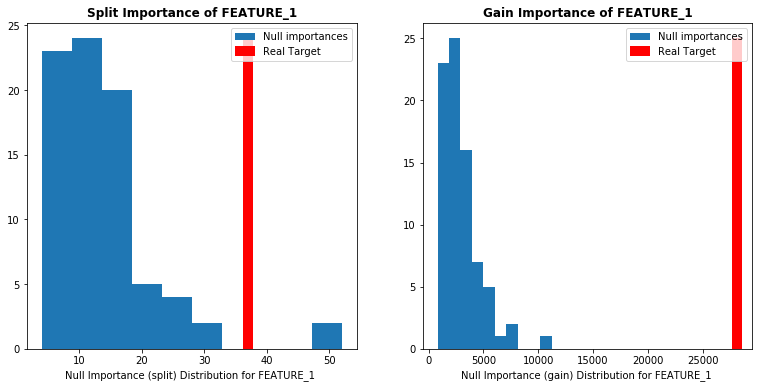

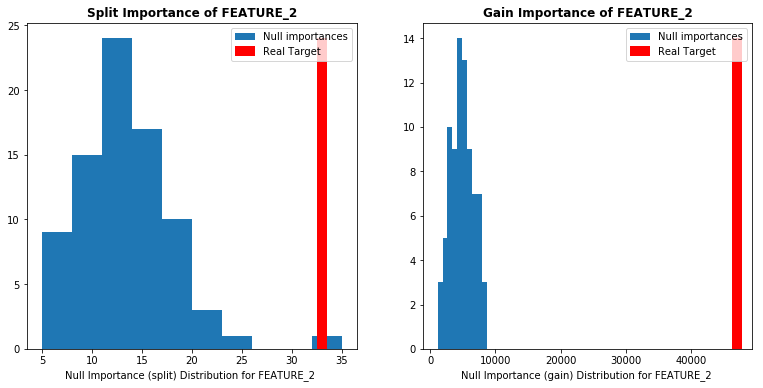

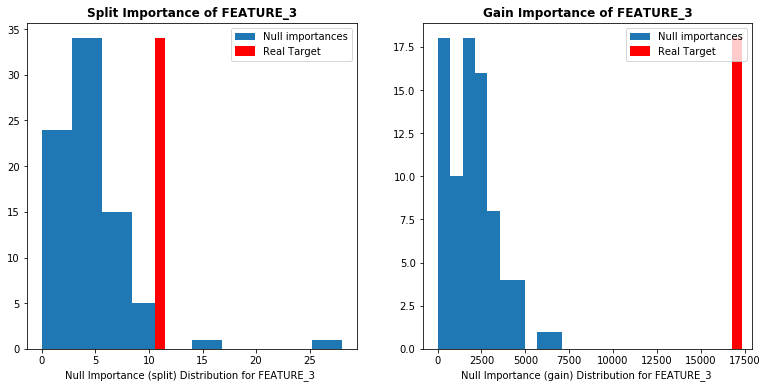

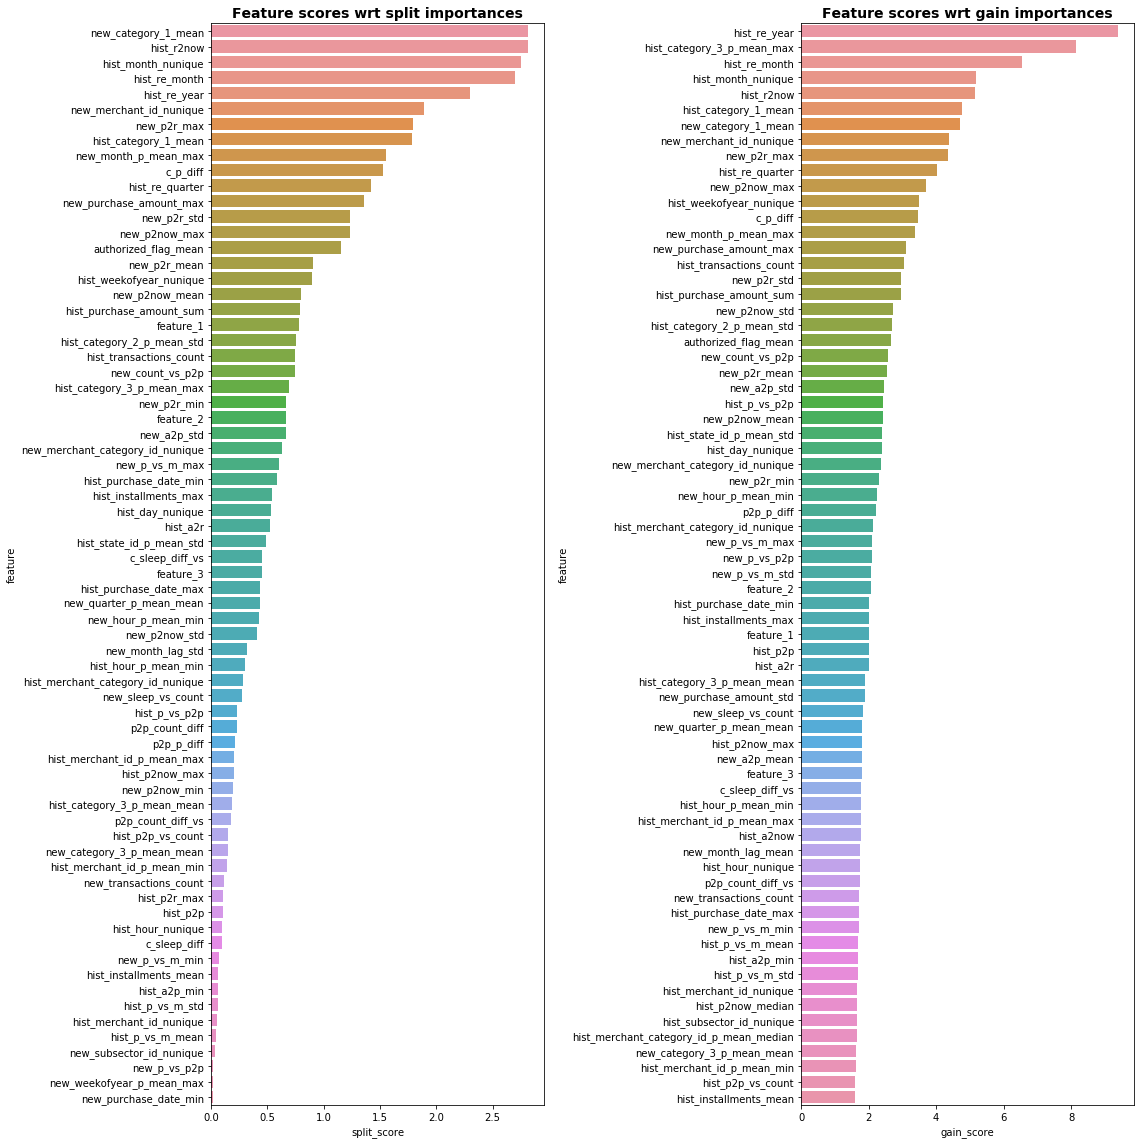

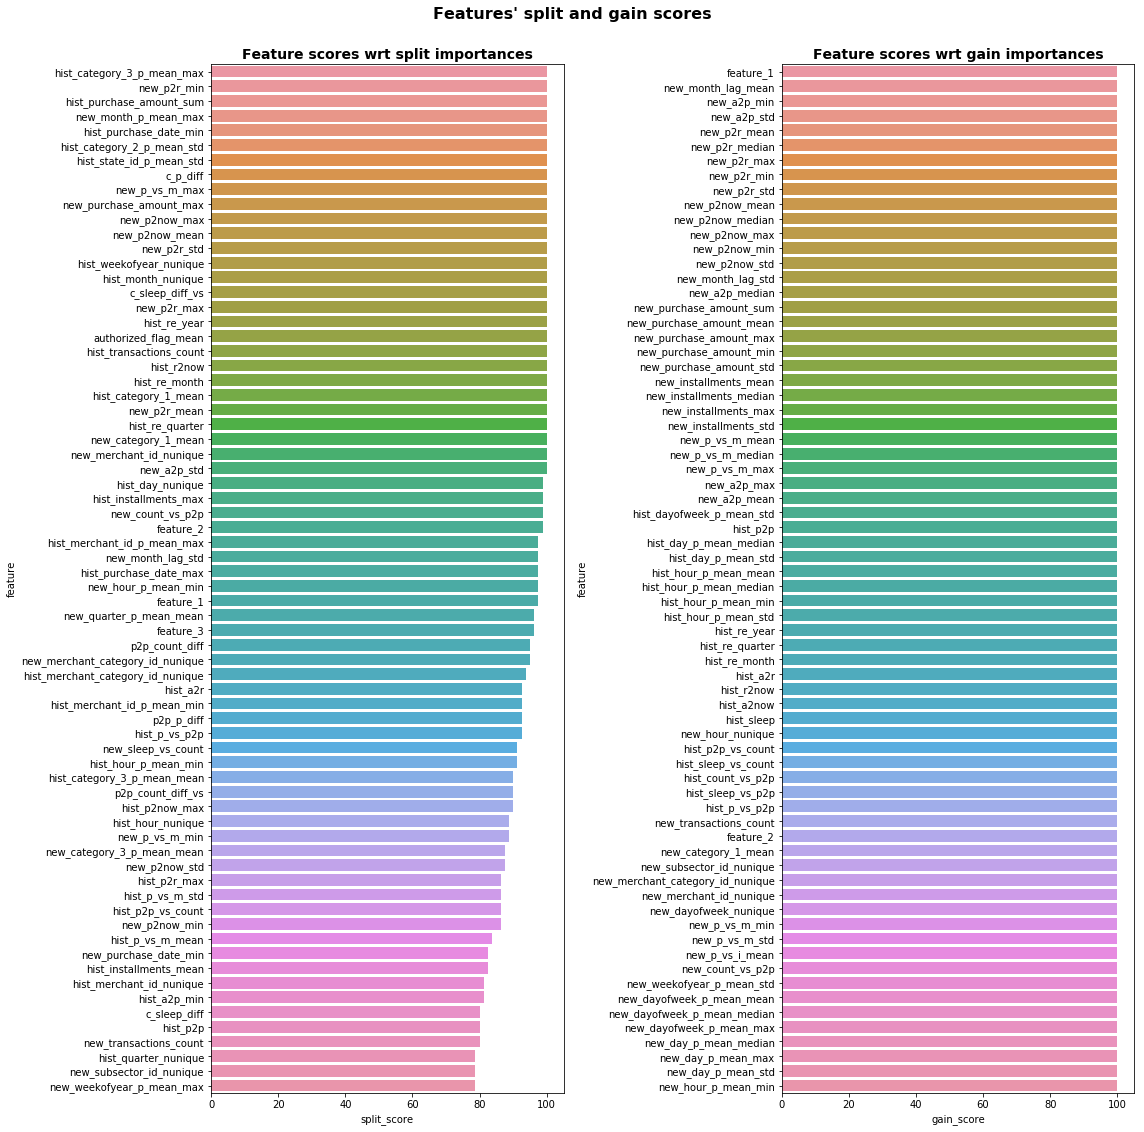

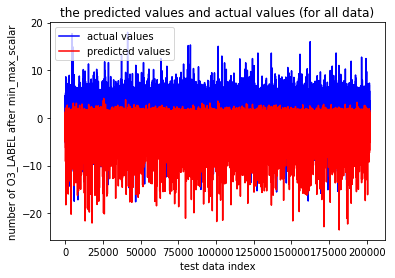

In [41]:
# plot the predicted values and actual values (for the test data)
fig, axs = plt.subplots()
axs.plot(np.squeeze(target[target>-20]), color='blue', label='actual values')
axs.plot(np.squeeze(oof), color='red', label='predicted values')
axs.set_title('the predicted values and actual values (for all data)')

plt.xlabel('test data index')
plt.ylabel('number of O3_LABEL after min_max_scalar')
plt.legend(loc='upper left')
plt.show()

In [77]:
# from sklearn.model_selection import RepeatedKFold
# folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2333)
# 去除异常值
train = train[train['outliers']==0]
folds = KFold(n_splits=n_fold, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

target = train['target']

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_feats)
#     trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / 10
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.59989	valid_1's rmse: 1.62981
[200]	training's rmse: 1.5688	valid_1's rmse: 1.60292
[300]	training's rmse: 1.5549	valid_1's rmse: 1.59313
[400]	training's rmse: 1.54593	valid_1's rmse: 1.58816
[500]	training's rmse: 1.53926	valid_1's rmse: 1.58546
[600]	training's rmse: 1.53368	valid_1's rmse: 1.58381
[700]	training's rmse: 1.5288	valid_1's rmse: 1.58275
[800]	training's rmse: 1.52438	valid_1's rmse: 1.58203
[900]	training's rmse: 1.52041	valid_1's rmse: 1.58164
[1000]	training's rmse: 1.5166	valid_1's rmse: 1.58128
[1100]	training's rmse: 1.51298	valid_1's rmse: 1.5811
[1200]	training's rmse: 1.5095	valid_1's rmse: 1.58085
[1300]	training's rmse: 1.50613	valid_1's rmse: 1.58069
[1400]	training's rmse: 1.50285	valid_1's rmse: 1.58063
[1500]	training's rmse: 1.49947	valid_1's rmse: 1.58055
[1600]	training's rmse: 1.49623	valid_1's rmse: 1.5805
[1700]	training's rmse: 1.49297	valid_1's rmse: 

In [ ]:
# from sklearn.model_selection import RepeatedKFold
# folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2333)
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

target = train['target']

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, fold_target)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_feats)
#     trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / 10
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

In [58]:

df_hist_trans = pd.read_csv('../input/historical_transactions.csv',parse_dates=['purchase_date'])
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv',parse_dates=['purchase_date'])

df_hist_ca=['authorized_flag','category_1','installments','category_3','merchant_category_id','merchant_id','category_2','state_id',\
          'subsector_id','purchase_amount' ]

hist_text_feature={}
gp=df_hist_trans.groupby('card_id')
for fea  in df_hist_ca:
    hist_text_feature[fea+"_hist_text"]=[]
hist_text_feature['card_id']=[]
for cid,cid_df in  gp:
    hist_text_feature['card_id'].append(cid)
    for  fea in  df_hist_ca:
        if fea=='card_id':
            continue
        hist_text_feature[fea+"_hist_text"].append(" ".join(cid_df[fea].astype(str).tolist()))
df_hist_text=pd.DataFrame(hist_text_feature)


new_mer_text_feature={}
gp=df_new_merchant_trans.groupby('card_id')
for fea  in df_hist_ca:
    new_mer_text_feature[fea+"_new_mer_text"]=[]
new_mer_text_feature['card_id']=[]
for cid,cid_df in  gp:
    new_mer_text_feature['card_id'].append(cid)
    for  fea in  df_hist_ca:
        if fea=='card_id':
            continue
        new_mer_text_feature[fea+"_new_mer_text"].append(" ".join(cid_df[fea].astype(str).tolist()))
        
df_new_mer_text=pd.DataFrame(new_mer_text_feature)

In [59]:
df_train=pd.merge(train,df_hist_text,how='left',on='card_id')
df_test=pd.merge(test,df_hist_text,how='left',on='card_id')

df_all=pd.concat([df_train,df_test])

text_fea=[i for i in df_all.columns if "text"in i]

from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse


cv=CountVectorizer(analyzer='word',token_pattern=u"(?u)\\b\\w+\\b")



for idx,i in enumerate(text_fea):
    cv.fit(df_all[i])
    tr_x=cv.transform(df_train[i])
    te_x=cv.transform(df_test[i])
    
    if idx==0:
        cv_Train_x=tr_x
        cv_Test_x=te_x
    else:
        cv_Train_x=sparse.hstack((cv_Train_x,tr_x))
        cv_Test_x=sparse.hstack((cv_Test_x,te_x))
    
print(cv_Train_x.shape,cv_Test_x.shape)


(201917, 494538) (123623, 494538)


In [63]:
from sklearn.feature_selection  import  SelectKBest
from sklearn.feature_selection  import  chi2

skb = SelectKBest(chi2,200)
skb.fit(cv_Train_x,df_train['outliers'].values)

cv_Train_x_filter = skb.transform(cv_Train_x)
cv_Test_x_filter = skb.transform(cv_Test_x)

print(cv_Train_x_filter.shape,cv_Test_x_filter.shape)


(201917, 200) (123623, 200)


In [64]:

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

train_x=df_train[features].values
test_x=df_test[features].values
train_y=df_train['target'].values

train_x=sparse.hstack((train_x,cv_Train_x_filter),'csr')
test_x=sparse.hstack((test_x,cv_Test_x_filter),'csr')
oof_train2 = np.zeros((train_x.shape[0],1))
oof_test2 = np.zeros((test_x.shape[0],1))
oof_test2_skf = np.zeros((5,test_x.shape[0],))

print(train_x.shape,test_x.shape)

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_x,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    x_tr,y_tr,x_te,y_te=train_x[trn_idx],train_y[trn_idx],train_x[val_idx],train_y[val_idx]
    trn_data = lgb.Dataset(x_tr,y_tr)
    val_data = lgb.Dataset(x_te,y_te)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_train2[val_idx] = clf.predict(x_te, num_iteration=clf.best_iteration).reshape(-1,1)

    oof_test2_skf[fold_,:]= clf.predict(test_x, num_iteration=clf.best_iteration)    
oof_test2 = oof_test2_skf.mean(axis=0)
mean_loss=np.sqrt(mean_squared_error(oof_train2.reshape(-1), target))
print(mean_loss)

(201917, 259) (123623, 259)
fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's rmse: 3.57589	valid_1's rmse: 3.66949
[400]	training's rmse: 3.48657	valid_1's rmse: 3.64484
[600]	training's rmse: 3.43084	valid_1's rmse: 3.63675
[800]	training's rmse: 3.38811	valid_1's rmse: 3.63277
[1000]	training's rmse: 3.35242	valid_1's rmse: 3.6302
[1200]	training's rmse: 3.31993	valid_1's rmse: 3.62928
[1400]	training's rmse: 3.2891	valid_1's rmse: 3.62923
[1600]	training's rmse: 3.26077	valid_1's rmse: 3.62942
[1800]	training's rmse: 3.23282	valid_1's rmse: 3.63018
[2000]	training's rmse: 3.20677	valid_1's rmse: 3.631
Early stopping, best iteration is:
[1518]	training's rmse: 3.27198	valid_1's rmse: 3.62892
fold 1
Training until validation scores don't improve for 500 rounds.
[200]	training's rmse: 3.57187	valid_1's rmse: 3.67505
[400]	training's rmse: 3.48434	valid_1's rmse: 3.65443
[600]	training's rmse: 3.4284	valid_1's rmse: 3.64758
[800]	training's rmse: 3.

In [65]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test2
sub_df.to_csv("sub/submission_%s.csv"%mean_loss, index=False)
mean_loss=np.sqrt(mean_squared_error(oof_train2.reshape(-1), target))
print(mean_loss)
train_prob=pd.DataFrame(oof_train2)
train_prob.columns=['class1']
train_prob.to_csv("oof/train_prob_%s.csv"%mean_loss,index=False)

test_prob=pd.DataFrame(oof_test2)
test_prob.columns=['class1']
test_prob.to_csv("oof/test_prob_%s.csv"%mean_loss,index=False)

np.save("train_y",target)

3.635948714908447
